In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import os
import numpy as np
import healpy as hp
import tensorflow as tf
import matplotlib.pyplot as plt

from deepsphere import healpy_layers

from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils import scales

In [3]:
n_side = 512
n_pix = hp.nside2npix(n_side)
l_min = 50
theta_fwhm = 30.0
l_max_naive = scales.angle_to_ell(theta_fwhm, arcmin=True, method="naive")

In [4]:
conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v6/linear_bias.yaml"
tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v6/linear_bias/tfrecords/fiducial/DESy3_fiducial_*.tfrecord"

pipe = FiducialPipeline(
    conf,
    params=[],
    with_lensing=True,
    with_clustering=True,
    apply_norm=False,
)

dset = pipe.get_dset(
    tfr_pattern,
    local_batch_size=1,
    n_noise=3,
)

for x, index in dset.take(1):
    print(x.shape)

24-02-05 06:49:44     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
24-02-05 06:49:44     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
24-02-05 06:49:46 fiducial_pip INF   Shuffling file names with shuffle_buffer = 16 
24-02-05 06:49:46 fiducial_pip INF   Interleaving with n_readers = 8 
24-02-05 06:49:46 fiducial_pip INF   Shuffling examples with shuffle_buffer = 64 
24-02-05 06:49:46 fiducial_pip INF   Batching into 1 elements locally 
24-02-05 06:49:47 fiducial_pip WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.exp

### unsmoothed map

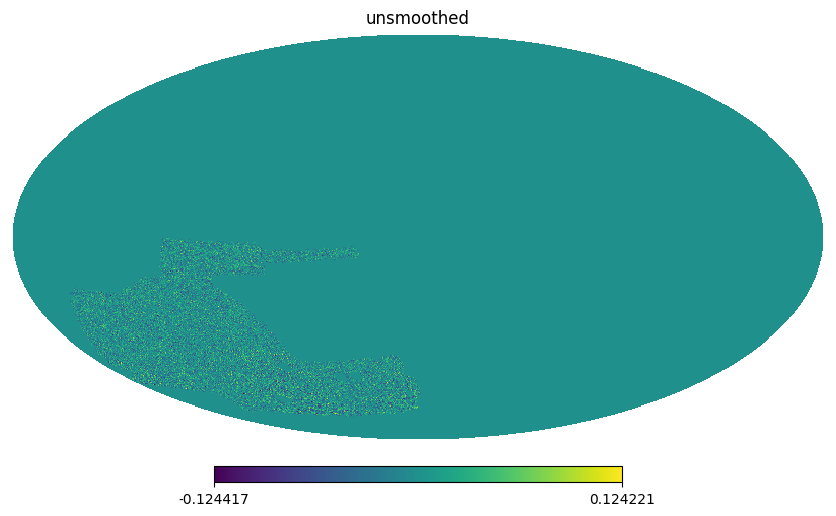

In [5]:
i_z = 0
data_vec_pix = pipe.data_vec_pix
raw_map = np.zeros(n_pix)
raw_map[data_vec_pix] = x[0,:,i_z]
raw_map = hp.reorder(raw_map, n2r=True)

hp.mollview(raw_map, title="unsmoothed")

In [6]:
raw_cls = hp.anafast(raw_map)

raw_map_smoothed_cls = scales.cls_to_smoothed_cls(
    raw_cls, 
    l_min=l_min, 
    theta_fwhm=theta_fwhm
)

### smoothed map

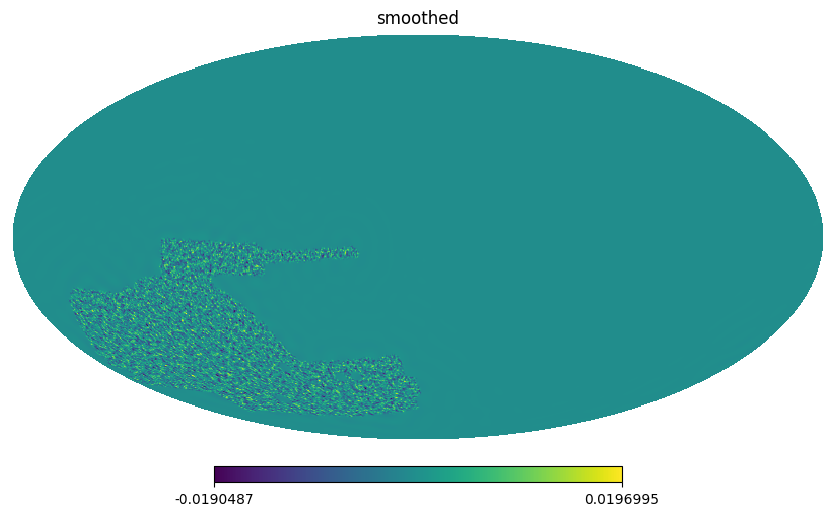

In [17]:
smoothed_map, direct_smoothed_alms = scales.map_to_smoothed_map(
    raw_map, 
    n_side, 
    l_min=l_min,
    theta_fwhm=theta_fwhm,
    nest=False,
)

hp.mollview(smoothed_map, title="smoothed")

direct_smoothed_cls = hp.alm2cl(direct_smoothed_alms)

In [8]:
smoothed_map_raw_cls = hp.anafast(smoothed_map)

### comparison

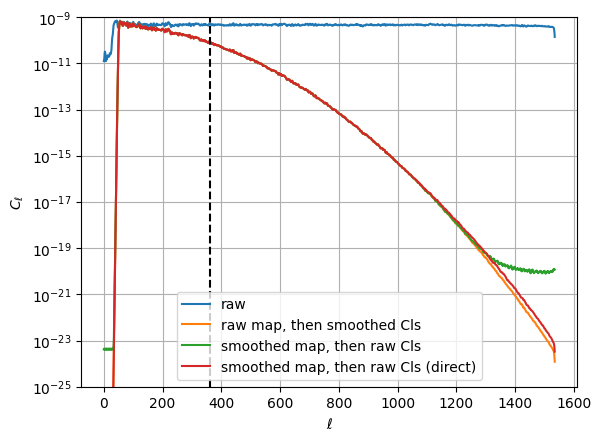

In [22]:
fig, ax = plt.subplots()
ax.plot(raw_cls, label="raw")
ax.plot(raw_map_smoothed_cls, label="raw map, then smoothed Cls")
ax.plot(smoothed_map_raw_cls, label="smoothed map, then raw Cls")
ax.plot(direct_smoothed_cls, label="smoothed map, then raw Cls (direct)")
ax.axvline(l_max_naive, color="k", linestyle="--")
ax.set(xlabel=r"$\ell$", ylabel=r"$C_\ell$", yscale="log", ylim=(1e-25,1e-9))
ax.legend()
ax.grid(True)

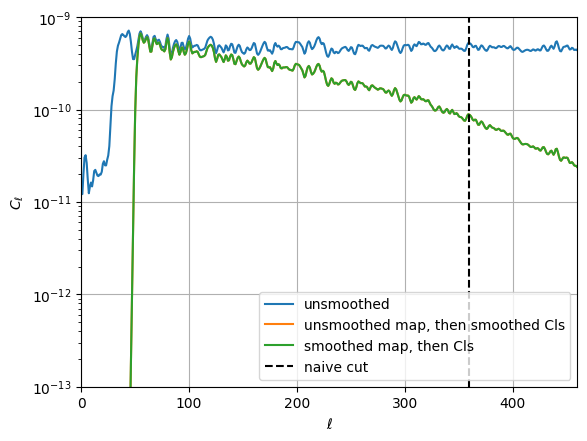

In [25]:
fig, ax = plt.subplots()
ax.plot(raw_cls, label="unsmoothed")
ax.plot(raw_map_smoothed_cls, label="unsmoothed map, then smoothed Cls")
ax.plot(smoothed_map_raw_cls, label="smoothed map, then Cls")
# ax.plot(direct_smoothed_cls, label="smoothed map, then raw Cls (direct)")
ax.axvline(l_max_naive, color="k", linestyle="--", label="naive cut")
ax.set(xlabel=r"$\ell$", ylabel=r"$C_\ell$", yscale="log", ylim=(1e-13, 1e-9), xlim=(0, l_max_naive+100))
ax.legend()
ax.grid(True)

# DeepSphere smoothing

In [27]:
smoothing_layer = healpy_layers.HealpySmoothing(
    nside=n_side,
    indices=pipe.data_vec_pix,
    nest=True,
    fwhm=theta_fwhm,
    arcmin=True,
    n_sigma_support=3
)
smoothing_layer = tf.keras.Sequential([smoothing_layer])



Using the per channel smoothing scale sigma = 12.74 arcmin,  fwhm = 30.00 arcmin
Creating tree for 464896 pixels and radius n_sigma_support * sigma = 38.22 arcmin
The maximal number of neighbors within that radius is 103


querying the tree: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


Successfully created the sparse kernel tensor


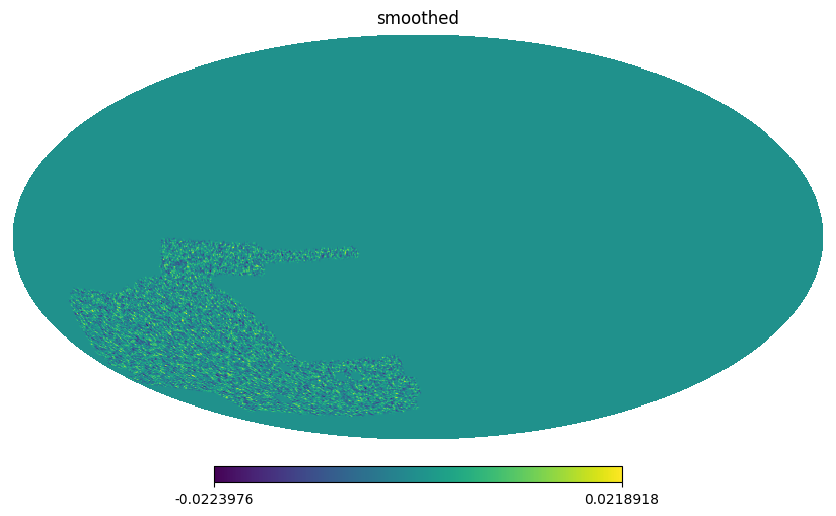

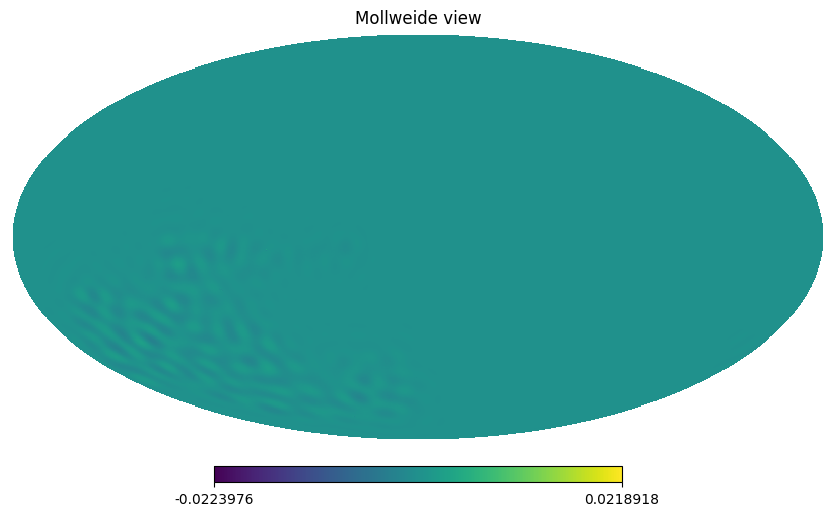

In [37]:
ds_smoothed_data_vector = smoothing_layer(x).numpy()[0,:,i_z]

ds_smoothed_map = np.zeros(n_pix)
ds_smoothed_map[data_vec_pix] = ds_smoothed_data_vector
ds_smoothed_map = hp.reorder(ds_smoothed_map, n2r=True)

vmin = ds_smoothed_map.min()
vmax = ds_smoothed_map.max()
hp.mollview(ds_smoothed_map, title="smoothed", min=vmin, max=vmax)
hp.mollview((smoothed_map - ds_smoothed_map), min=vmin, max=vmax)